# Random Forest
### Random Forest is an ensemble machine learning algorithm that leverages multiple decision trees to enhance predictive accuracy and mitigate overfitting, a common pitfall of individual trees. By aggregating predictions from a collection of trees - each trained on a random subset of data and features - it reduces variance and improves generalization, making it suitable for both classification (e.g., predicting wine quality) and regression tasks. The algorithm assumes that the trees are decorrelated, which is achieved through bagging and feature randomness, though it does not require strict data distribution assumptions. Its high accuracy and resilience to noise make it a powerful tool, but the trade-off includes slower training and inference times due to the ensemble nature, as well as reduced interpretability compared to a single decision tree.

### Use Random Forest as a go-to model for  predictions, with hyperparameter tuning (e.g., number of trees, max depth) to balance performance and computational cost, especially for deployment-ready systems.

| Aspect | Details |
| :- | :- |
| Use For           | Classification (e.g., fraud detection, disease diagnosis)<br>Regression (e.g., house price prediction, quality scoring) |
| Key Assumptions   | - Decorrelation of individual trees via bagging and feature randomness<br>- Independent observations<br>- Sufficient data for ensemble diversity |
| Advantages        | - High accuracy through ensemble averaging<br>- Robust to overfitting and noise<br>- Handles mixed data types with minimal preprocessing |
| Disadvantages     | - Slower training and prediction due to multiple trees<br>- Less interpretable than a single decision tree<br>- Memory-intensive with large ensembles |
| Avoid When        | - Real-time applications requiring low latency<br>- Need for highly interpretable models<br>- Very small datasets lacking diversity |
| Real-World Use Case | Fraud detection (e.g., identifying fraudulent transactions based on spending patterns)<br>Medical diagnosis (e.g., predicting patient outcomes from multiple health metrics) |

## Problem Description: 
### Predict the quality of red wine (rated from 0 to 10) based on physicochemical properties like alcohol content, pH, and volatile acidity. This is a multi-class classification problem where Random Forest can model complex relationships between features and quality ratings.

Using Kaggle dataset https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

## Modified Approach to improve accuracy:
- feature engineering adding new features
- creating synthetic data and adding to source data
- Bayesian optimised search for best hyperparameters

In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


2025-06-12 15:40:12.780556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 15:40:12.939541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749739212.997795  259508 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749739213.013856  259508 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749739213.139371  259508 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def setup_gpu():
    ## tf version
    print("TensorFlow version:", tf.__version__)

    #### GPU Optimisation code ####
    print("GPUs:",tf.config.list_physical_devices('GPU'))

    print("GPUs: Allocate GPU Memory and create a new session")

    # Get the GPU memory fraction to allocate
    gpu_memory_fraction = 0.5

    # Create GPUOptions with the fraction of GPU memory to allocate
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

    # Create a session with the GPUOptions
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
setup_gpu()

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: Allocate GPU Memory and create a new session


I0000 00:00:1749739216.081821  259508 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
project_dir = './04_random_forest'

# load  dataset
data = pd.read_csv(project_dir + '/data/winequality-red.csv')
print("Dataset loaded, shape:", data.shape)

# feature engineering: add total acidity - to increase accuracy - by itself this increases accuracy from 0.63 to 0.7
data['total_acidity'] = data['fixed acidity'] + data['volatile acidity'] + data['citric acid']
# feature engineering: acidity_ratio, sugar_to_acid_ratio
data['acidity_ratio'] = data['total_acidity'] / data['pH'].replace(0, 0.01)
data['sugar_to_acid_ratio'] = data['residual sugar'] / data['total_acidity'].replace(0, 0.01) 

# select key features and target variable
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'total_acidity', 'acidity_ratio', 'sugar_to_acid_ratio']

X = data[features] 
y = data['quality']
print("Features shape:", X.shape, "Target shape:", y.shape)

Dataset loaded, shape: (1599, 12)
Features shape: (1599, 14) Target shape: (1599,)


In [5]:
# generate synthetic data (x4 the original size)
np.random.seed(40)  # For reproducibility
n_original = len(data)
n_synthetic = n_original * 10  
synthetic_X = np.zeros((n_synthetic, len(features)))
synthetic_y = np.zeros(n_synthetic, dtype=int)

# calculate quality-specific covariance matrices
quality_stats = {}
for quality in data['quality'].unique():
    quality_data = data[data['quality'] == quality][features].values
    quality_stats[quality] = {
        'mean': quality_data.mean(axis=0),
        'cov': np.cov(quality_data.T)
    }

# oversample rare classes
quality_dist = data['quality'].value_counts(normalize=True)
rare_classes = [3, 8]  # Classes with few samples
rare_factor = 3  # Triple the proportion for rare classes
adjusted_dist = quality_dist.copy()
for qc in rare_classes:
    adjusted_dist[qc] *= rare_factor
adjusted_dist = adjusted_dist / adjusted_dist.sum()

for i in range(n_synthetic):
    quality = np.random.choice(data['quality'].unique(), p=adjusted_dist)
    mean = quality_stats[quality]['mean']
    cov = quality_stats[quality]['cov']
    sample = multivariate_normal.rvs(mean=mean, cov=cov)
    synthetic_X[i] = np.clip(sample, X.min(), X.max())
    synthetic_y[i] = quality

# Combine original and synthetic data
X_combined = np.vstack((X.values, synthetic_X))
y_combined = np.concatenate((y.values, synthetic_y))

In [6]:
# scale features to improve model performance
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

In [7]:
# split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_combined_scaled, y_combined, test_size=0.2, random_state=42, stratify=y_combined)
print("Train set shape:", X_train.shape, "Test set shape:", X_test.shape)


# define the hyperparameter search space for Bayesian optimization
search_space = {
    'n_estimators': Integer(100, 1000),  # expanded to 1000
    'max_depth': Integer(10, 100, 'uniform'),  # expanded to 100
    'min_samples_split': Integer(2, 20),  # broader range
    'min_samples_leaf': Integer(1, 10),  # broader range
    'max_features': Categorical(['sqrt', 'log2', None]),
    'max_samples': Real(0.1, 0.9, 'uniform'),
    'class_weight': Categorical(['balanced', 'balanced_subsample', None]),  # add class weighting
}

Train set shape: (14071, 14) Test set shape: (3518, 14)


In [8]:
# set up BayesSearchCV
rf_model = RandomForestClassifier(random_state=40)
bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_space,
    n_iter=50,  # number of iterations for Bayesian optimization
    cv=5,
    n_jobs=-1,  # utilize all CPU cores for parallelization
    scoring='accuracy',
    random_state=40
)

In [9]:
# perform hyperparameter search
bayes_search.fit(X_train, y_train)  

best_rf = bayes_search.best_estimator_
print(f'Best Parameters: {bayes_search.best_params_}')

Best Parameters: OrderedDict({'class_weight': None, 'max_depth': 32, 'max_features': 'log2', 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000})


In [10]:
# predict and evaluate the model
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.63
Confusion Matrix:
[[  29    1   25    7    0    0]
 [   3    7   71   33    2    0]
 [   4    1 1117  332    5    0]
 [   1    0  390  892   63    4]
 [   0    0   18  245  150    7]
 [   0    0    0   43   38   30]]
Classification Report:
              precision    recall  f1-score   support

           3       0.78      0.47      0.59        62
           4       0.78      0.06      0.11       116
           5       0.69      0.77      0.73      1459
           6       0.57      0.66      0.61      1350
           7       0.58      0.36      0.44       420
           8       0.73      0.27      0.39       111

    accuracy                           0.63      3518
   macro avg       0.69      0.43      0.48      3518
weighted avg       0.64      0.63      0.62      3518



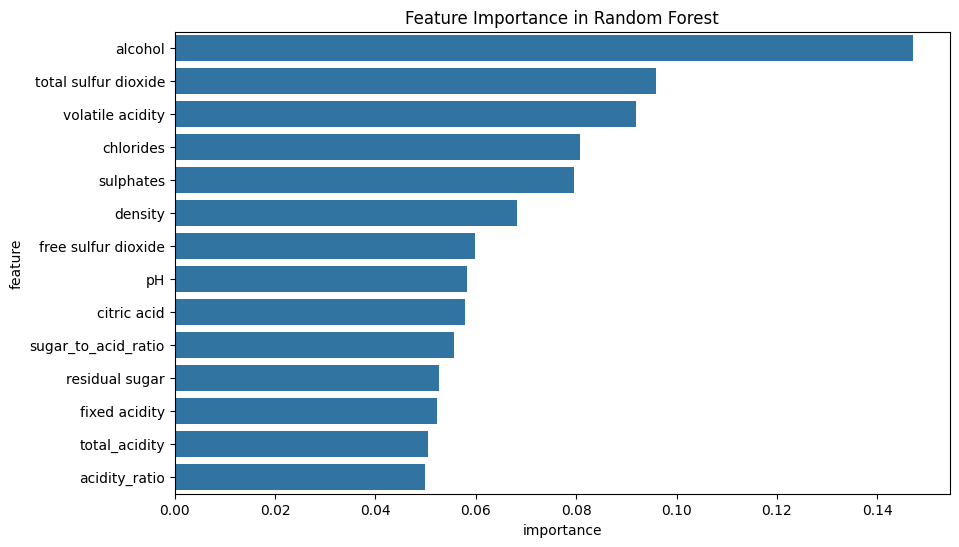

In [11]:
# visualize feature importance
feature_importance = pd.DataFrame({'feature': features, 'importance': best_rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Random Forest')
plt.show()

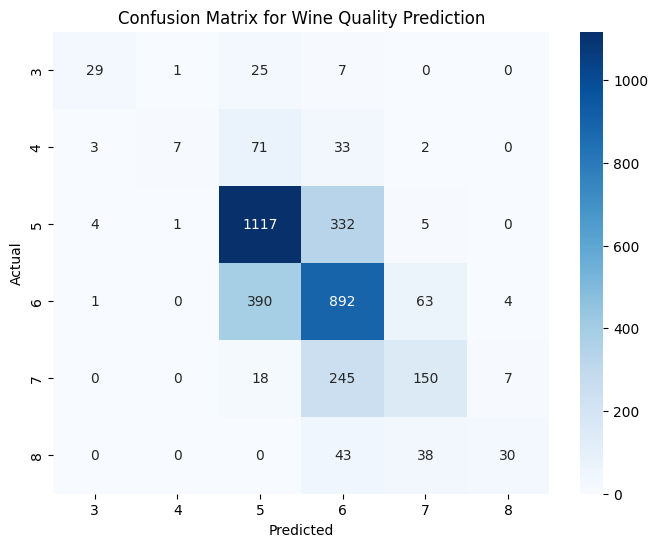

In [12]:
# visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(data['quality'].unique()), yticklabels=sorted(data['quality'].unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Wine Quality Prediction')
plt.show()

In [13]:
# save the trained model2 to a file using joblib for later use
model_dir = project_dir + '/model' 
os.makedirs(model_dir, exist_ok=True) 
model_filename = os.path.join(model_dir, 'wine_quality_model2.pkl') 
joblib.dump(best_rf, model_filename) 
print(f'Model saved as {model_filename}')

Model saved as ./04_random_forest/model/wine_quality_model2.pkl


In [14]:
# load the model and run a prediction test 
loaded_model = joblib.load(model_filename)

# for Wine Quality, use a sample input instead of test.csv (since no separate test file is provided)
print("Model fitted attributes:", hasattr(loaded_model, 'estimators_'))  # Should be True if fitted
sample_data = pd.DataFrame(
    [[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 8.1, 0.23, 0.24]],
    columns=features
)
sample_input_scaled = scaler.transform(sample_data)  # Scale the DataFrame
if hasattr(loaded_model, 'predict'):  # Ensure predict method exists
    sample_prediction = loaded_model.predict(sample_input_scaled)
    print(f'Predicted Wine Quality for sample input: {sample_prediction[0]}')
else:
    print("Model not fitted correctly after loading.")

Model fitted attributes: True
Predicted Wine Quality for sample input: 5


/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
